In [6]:
from matplotlib import pyplot as plt
import numpy as np
from scipy import stats
import pandas as pd
from IPython.display import HTML, IFrame, Image, SVG, Latex
import ROOT
from ROOT import RooFit, RooStats
%matplotlib inline
#%matplotlib nbagg
#%matplotlib notebook
from ipywidgets import interact, interactive, fixed

In [7]:
from matplotlib import rcParams
rcParams.update({'font.size': 20})
HTML('<link rel="stylesheet" href="custom.css" type="text/css">')

In [8]:
#from notebook.services.config import ConfigManager
#cm = ConfigManager()
#cm.update('livereveal', {
#          'theme': 'sans',
#          'transition': 'zoom',
#})

In [9]:
def iter_collection(rooAbsCollection):
    iterator = rooAbsCollection.createIterator()
    object = iterator.Next()
    while object:
        yield object
        object = iterator.Next()

In [10]:
def RooDataSet2pandas(data):
    nevents = data.numEntries()
    columns = [x.GetName() for x in iter_collection(data.get(0))]
    return pd.DataFrame([[x.getVal() for x in iter_collection(data.get(ievent))] for ievent in xrange(nevents)], columns=columns)

# Lecture 1

<p style="text-align: center;"><i class="icon-user icon-2x"> ruggero.turra@mi.infn.it</i></p>
<br/>

## Content of the lecture

   * Basic notion you should already have
   * Definition of significance
   * Introduction to inferential statistics
   * Counting experiments
   * RooFit / RooStats examples

## Intro to the lectures
   * This is not a course on [RooFit](https://root.cern.ch/roofit) / [RooStats](https://twiki.cern.ch/twiki/bin/view/RooStats/WebTopicList) / ...
   * This is not a course of python / [numpy](http://www.numpy.org/) / [matplotlib](http://matplotlib.org/) / ...
   * I have just collected some examples that can be interesting for your studies with the minimal-needed theory
   
These lectures are available on https://github.com/wiso/StatisticsLectures as [jupyter](http://jupyter.org/) notebook. They can be shown as interactive slides using [RISE](https://github.com/damianavila/RISE). It works also with a simple `jupyter nbconvert --to slides file.ipynb --post serve`, but style is not optimized.

## Resources

* [Kyle Cranmer](http://orcid.org/0000-0002-5769-7094) [lectures](https://indico.cern.ch/event/117033/other-view?view=standard) and [proceedings](https://cds.cern.ch/record/2004587/files/arXiv:1503.07622.pdf) at 2011 ESHEP (see page 3 for many books)
* Kyle Cranmer [lectures](https://indico.cern.ch/event/243641/) for summer students in 2013
* Glen Cowan [Statistical Data Analysis for Particle Physics](http://www.pp.rhul.ac.uk/~cowan/stat_aachen.html) and [other](http://www.pp.rhul.ac.uk/~cowan/) lectures

In [11]:
IFrame("https://indico.cern.ch/event/117033/contribution/19/attachments/55755/80228/Cranmer_L1.pdf", 800, 600)

In [12]:
IFrame("http://www.pp.rhul.ac.uk/~cowan/stat_aachen.html", 800, 600)

[Luca Lista](http://people.na.infn.it/~lista/Statistics/) with RooStats examples

In [13]:
IFrame('http://people.na.infn.it/~lista/Statistics/', width=900, height=400)

LHC discovery related:

   * Eilam Gross [LHC Statistics for Pedestrians](http://cds.cern.ch/record/1099994/files/p205.pdf)
   * [Asymptotic formulae for likelihood-based tests of new physics](http://arxiv.org/pdf/1007.1727v3.pdf)
   * [Procedure for the LHC Higgs boson search
combination in Summer 2011](https://cds.cern.ch/record/1379837/files/NOTE2011_005.pdf)

   
Others:
   * Gerhard Bohm, Günter Zech ["Introduction to Statistics and Data
Analysis for Physicists"](http://www-library.desy.de/preparch/books/vstatmp_engl.pdf)
   * Roger Barlow ["Systematic Errors: Facts and Fictions"](http://arxiv.org/pdf/hep-ex/0207026v1.pdf)
   * Grégory Schott [RooStats for Searches](http://indico.cern.ch/event/107747/contribution/25/attachments/24332/35016/schott_2011.01.17__RooStats_talk.pdf)


> Statistics - A subject which most statisticians find difficult but in which nearly all physicians are expert.

* Statistics seems easy, since usually problems can described with a simple language. But it is not...
* Easy questions: do we have discovered the Higgs boson?

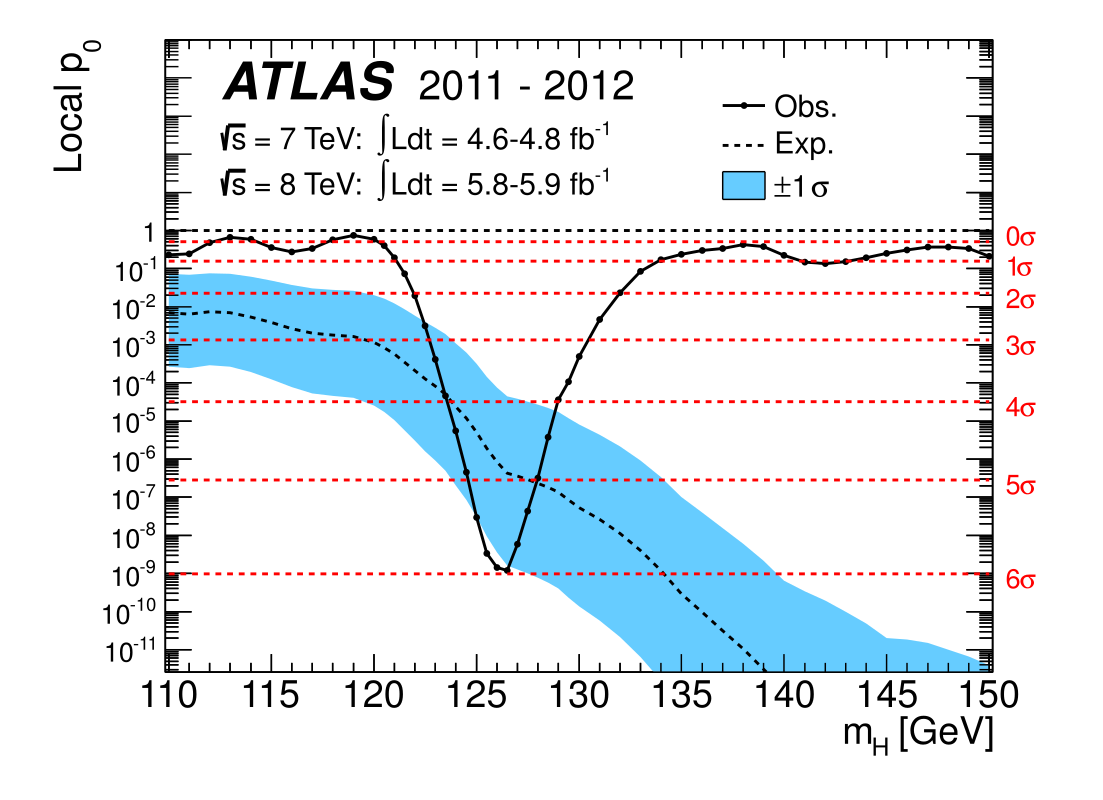

In [14]:
Image('higgs_discovery.png', width='80%')

## Basic concepts you should already have

Given a (continuos) random variable $X$:
   * <strong>CDF</strong>: $F_X(x) = P(X\leq x)$
   * <strong>PDF</strong>: $f_X = \frac{dF_X}{dx}$
   * <strong>SF</strong>: $P(X>x) = 1 - F_X(x)$
   * <strong>Expected value</strong>
   $E[X] = \mu = \int x f_X(x) dx$
   * <strong>Variance</strong>: $V[X] = E[(X - \mu)^2]=E[X^2]-E[X]^2$
   * <strong>Covariance</strong>:   
   $\operatorname{cov}(X,Y) = \operatorname{E}{\big[(X - \operatorname{E}[X])(Y - \operatorname{E}[Y])\big]} =  \operatorname{E}\left[X Y\right] - \operatorname{E}\left[X\right]\operatorname{E}\left[Y\right]$


### Question
Explain the name "survival function"

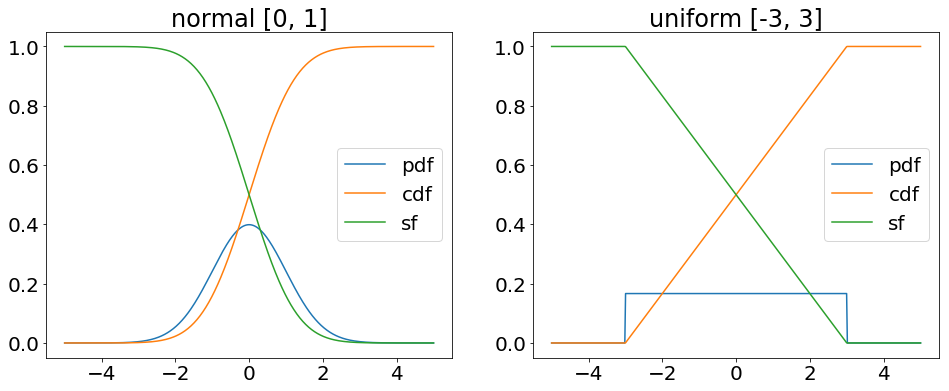

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
x = np.linspace(-5, 5, 500)
dists = stats.norm(0, 1), stats.uniform(-3, 6)
labels = "normal [0, 1]", "uniform [-3, 3]"
for ax, dist, label in zip(axs, dists, labels):
    ax.plot(x, dist.pdf(x), label='pdf')
    ax.plot(x, dist.cdf(x), label='cdf')
    ax.plot(x, dist.sf(x), label='sf')
    ax.legend()
    ax.set_title(label)

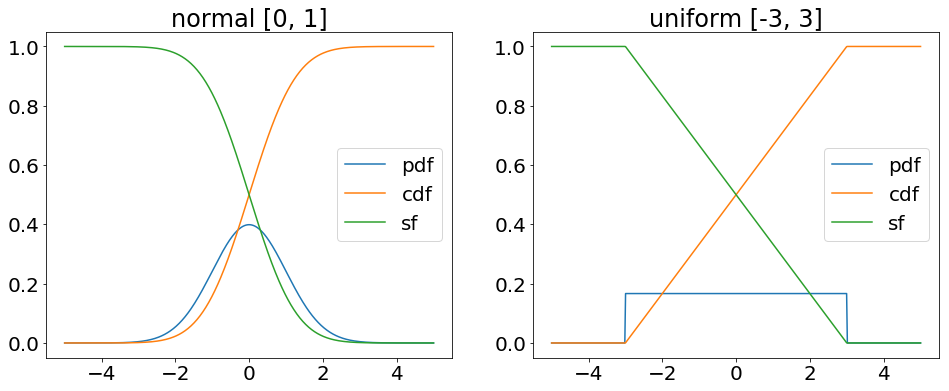

In [16]:
fig

## Example
   * Having a sample $\{x_i\}_i^n$, it is well know that 
   $$s^2 = \frac{1}{n-1} \sum_{i=1}^n \left(x_i - \overline{x} \right)^2 \qquad \text{where}\quad \overline{x}=\frac{1}{n}\sum_{i=1}^n x_i$$
   is an unbiased estimator for the variance $V[X]$
   * Unbias estimator: $E[\text{bias}]=E[s^2 - V[X]] = 0$  (or $E[s^2] = V[X]$)
   * Show analytically that $\sqrt{s^2}$ is not an unbiased estimator for the standard deviation $\sigma_X=\sqrt{V[X]}$ (hint: $E$ is linear, $\sqrt{\,\,\,}$ is not)

#### Non-analytical solution

Let generate many pseudo-experiments (toys), to see the bias of $\sqrt{s^2}$. Every toy is made by a normal sample.

In [17]:
POPULATION_STD_DEV = 3  # standard deviation of the population
SIZE = 5                # size of the sample (for every toy)
NTOYS = 1000            # number of toys

# create the random variable (in this case normal distributed)
X = stats.norm(loc=0, scale=POPULATION_STD_DEV)

# consider two versions of s^2 (with/without Bessel correction)
all_bias_std, all_bias_std_corr = [], []

for itoy in range(NTOYS):
    sample = X.rvs(SIZE)  # generate a sample from the random variable
    
    # compute the bias for the two definitions
    all_bias_std.append(np.std(sample) - POPULATION_STD_DEV)
    all_bias_std_corr.append(np.std(sample, ddof=1) - POPULATION_STD_DEV)

Much faster code with vectorization

In [18]:
NTOYS = 1000000
X = stats.norm(loc=0, scale=POPULATION_STD_DEV)
samples = X.rvs((NTOYS, SIZE))
all_bias_std = np.std(samples, axis=1) - POPULATION_STD_DEV
all_bias_std_corr = np.std(samples, axis=1, ddof=1) - POPULATION_STD_DEV

In [19]:
# plot it
mean_bias_non_corr, err_bias_non_corr = [f(all_bias_std) for f in (np.mean, stats.sem)]
mean_bias_corr, err_bias_corr = [f(all_bias_std_corr) for f in (np.mean, stats.sem)]

fig, ax = plt.subplots(figsize=(11, 7))
bins = np.linspace(-1.2 * POPULATION_STD_DEV, 2 * POPULATION_STD_DEV, 100)
ax.hist(all_bias_std, bins, histtype='step', density=True, label='non-corr %.3f$\pm$%.3f' % (mean_bias_non_corr, err_bias_non_corr))
ax.hist(all_bias_std_corr, bins, histtype='step', density=True, label='corr %.3f$\pm$%.3f' % (mean_bias_corr, err_bias_corr))
bias_pdf = stats.chi(df=SIZE-1, loc=-POPULATION_STD_DEV, scale = POPULATION_STD_DEV / (np.sqrt(SIZE - 1) ))
bias_pdf_integral_window = bias_pdf.cdf(bins.max()) - bias_pdf.cdf(bins.min())
ax.plot(bins, bias_pdf.pdf(bins) / bias_pdf_integral_window, label='$\chi_{n-1}((\mathrm{bias} + \sigma) \sqrt{n - 1} / \sigma)$')
ax.set_xlabel('bias')
ax.legend()
ax.axvline(0, linestyle='--')
plt.close()

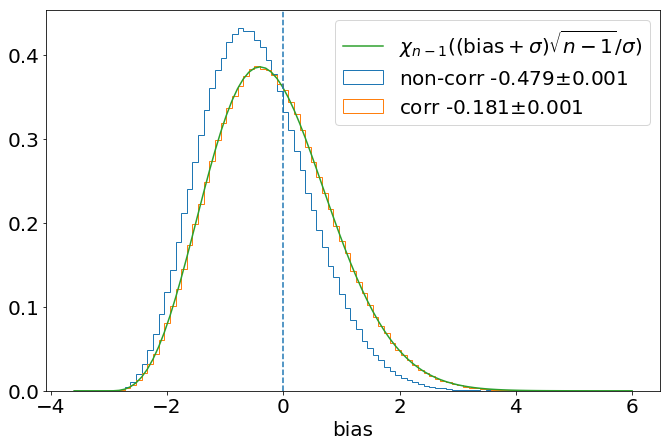

In [20]:
fig

<small>For a normal distribution $y^2\sim\chi^2_{n-1}$ with $y=\sqrt{n-1}s/\sigma$ by [Cochran's theorem](https://en.wikipedia.org/wiki/Cochran%27s_theorem), so in principle it is possibile to have an analytical expression for an unbiased estimator</small>

We have computed the mean of the bias for a finite number of toys and it seems to be different from 0. Can we draw a conclusions from these toys? Is the estimator biased? 

   * Can we prove that the expected value of the bias $E(\text{bias})$ is not zero?
   * Can we exclude that $E(\text{bias})$ is zero?
   * Can we do from a finite set of random toys?
   * How probable is that we got a very particular set of toys which lead us to a wrong conclusion?

   * <strong>Statistic</strong>: a function of the data (the mean, the number of observed events, ...)
   * <strong>p-value</strong>: the probability to obtaining a result equal to or "more extreme" than what was actually observed
      * What "more extreme" means? It depends on question we want to answer (the hypothesis you want to test)
   
   
   * <strong>Conditional probability</strong> $P(A|B) = P(A\cap B) / P(B)$
      - 2% $\stackrel{?}{=}$ P(to be pregnant|to be woman) $\neq$ P(to be woman|to be pregnant) = 1
      - P(data|theory) $\neq$ P(theory|data)
   * <strong>Bayes theorem</strong> $P(A|B)P(B) = P(B|A)P(A)$
      * $P(\text{theory|data}) = P(\text{data|theory}) P(\text{theory})\quad$ (neglecting $\,/P(\text{data})$)
   * <strong>Likelihood</strong>: $\mathcal{L}(\theta) = P(\text{data}|\theta)$

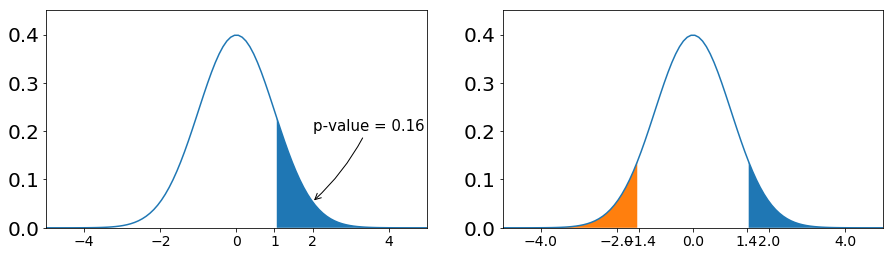

In [21]:
fig_gaussian, axs = plt.subplots(1, 2, figsize=(15, 4))
x = np.linspace(-5, 5, 100)
norm = stats.norm
y = norm.pdf(x)
z = 1.
mask = x > z
for ax in axs.flat:
    ax.plot(x, y)
axs[0].fill_between(x[mask], y[mask])
pvalue = norm.sf(z)
axs[0].annotate("p-value = %.2f" % pvalue, fontsize=15, xy=(2, norm.pdf(2)), xytext=(z*2, 0.2), ha='left', arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-0.1", facecolor='black'))
axs[0].set_xticks(list(axs[0].get_xticks()) + [z])
for tick in axs[0].xaxis.get_major_ticks():
    tick.label.set_fontsize(14) 

z = norm.isf(pvalue / 2.)
axs[1].fill_between(x[x>z], y[x>z])
axs[1].fill_between(x[x<-z], y[x<-z])
axs[1].set_xticks(list(axs[1].get_xticks()) + [z, -z])
for tick in axs[1].xaxis.get_major_ticks():
    tick.label.set_fontsize(14) 
    
for ax in axs.flat:
    ax.set_xlim(-5, 5)
    ax.set_ylim(0, 0.45)

plt.show()


## Hypothesis testing

A statistical hypothesis is a hypothesis that is testable on the basis of observing a process that is modeled via a set of random variables

A statistical hypothesis test is a method of statistical inference

The goal of the hypothesis testing is to determine if the null ($H_0$) hypothesis can be
rejected. A statistical test can either reject (prove false) or fail to reject (fail to
prove false) a null hypothesis, but never prove it true (i.e., failing to reject a null
hypothesis does not prove it true).


### Example (binomial test one / two tail)

Are the students of this lecture equally distributed between male and female? Let's define the null hypothesis: "The students are equally distributed" and try to exclude it computing the p-value (decide to exclude if p-value < 5%). 

The model is a binomial model, if we define $m = $ observed number of male student, $N$ the total number of student, $p$ the probability to have a male student, the null hypothesis is $p=1/2$.

$$ H_0: M\sim B(m| N, 1/2)$$

Compute the p-value of the data, assuming $H_0$ to be true. What "more extreme" means in this case? Since usually there are more male students, "more extreme" means "more male student than the observed".

$$\text{p-value} = P(m\geq m_{obs}|H_0) = \sum_{m\geq m_{obs}} B(m|N, 1/2)$$

In [22]:
def nmale_experiment(N=10, nmale_obs=7):
    pvalue = stats.binom(N, 0.5).sf(nmale_obs) + \
             stats.binom(N, 0.5).pmf(nmale_obs)    # ==
    print("pvalue = ", pvalue, "can't exclude H0" if pvalue > 0.05 else "H0 excluded")
    x = np.arange(0, 15)
    plt.plot(x, stats.binom(N, 0.5).pmf(x), drawstyle='steps-post', label='$P(m|H_0)$')
    plt.annotate('p-value', xy=(nmale_obs + 0.5, .02), xytext=(10, .1), arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-0.1", facecolor='black'))
    plt.axvline(nmale_obs, color='k', ls='--'); plt.xlabel('$m$');
    plt.legend(); plt.show()
interact(nmale_experiment);

interactive(children=(IntSlider(value=10, description='N', max=30, min=-10), IntSlider(value=7, description='n…

pvalue =  0.17187500000000017 can't exclude H0


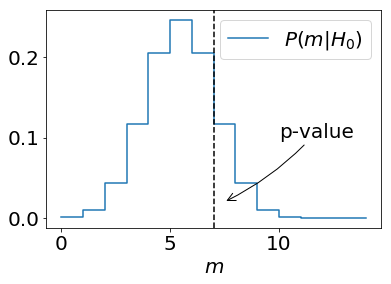

In [23]:
nmale_experiment()  # only this is rendered on github

What if we all the students are female? Using the previous test we will find a very high p-value, and so we were not able to reject the null hypothesis. The problem is that we are looking to the right tail (more males). In that case we should change our definition of "more extreme".

Another solution is to perform a two-tailed test. In that case "more extreme" simply means less probable. What is the probability to observe a number of male, less probable than the one actually observed? Note that in this case we are counting as "more extreme" cases where there are two many males (as before) or too few males.

$$\text{p-value} = \sum_{m: P(m|H_0) \leq P(m_{obs}|H_0)} P(m|H_0)$$

In [24]:
def nmale_experiment2(N=10, nmale_obs=7):
    M = stats.binom(N, 0.5)
    pobs = M.pmf(nmale_obs)
    all_p = [M.pmf(m) for m in range(0, N + 1)]
    pvalue = sum([p for p in all_p if p <= pobs + 1E-5])
    print("pvalue = ", pvalue, "can't exclude H0" if pvalue > 0.05 else "H0 excluded")
    x = np.arange(0, 15)
    plt.plot(x, stats.binom(N, 0.5).pmf(x), drawstyle='steps-post', label='$P(m|H_0)$')
    plt.axvline(nmale_obs, color='k', ls='-'); plt.xlabel('$m$');
    plt.axvline(N - nmale_obs + 1, color='k', ls='--'); plt.show()
interact(nmale_experiment2);

interactive(children=(IntSlider(value=10, description='N', max=30, min=-10), IntSlider(value=7, description='n…

This is an important test: binomial test

In [25]:
nmale_obs = 7
N = 10
stats.binom_test(nmale_obs, N, 0.5)

0.3437499999999999

### Exercize:
Show that the two-tail p-value for a binomial with $p=1/2$ is two times the one-tail p-value (this is true only for $p=1/2$).

## Normal significance

Usually p-values are translated in a more-friendly normal-significance (number of sigmas) $z$. With the one-tail definition this is the value (quantile) corresponding to a certain p-value for a standard gaussian:

$$ \int_z^\infty N[x| 0, 1] dx = \text{p-value}$$

or $ \int_z^\infty + \int_{-\infty}^{-z} N[x|0,1] dx = \text{p-value}$ for the two-tail definition.

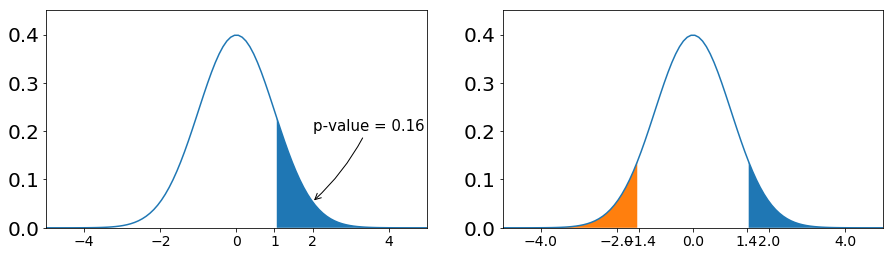

In [26]:
fig_gaussian

$$ \int_z^\infty N[x| 0, 1] dx = \text{p-value}$$

Taking into account the definition of the cumulative density function of a normal distribution, $\Phi(z) = \int_{-\infty}^{z} N[x| 0, 1] dx$, this can be written as:

$$ z = \Phi^{-1}(1 - \text{p-value})$$

or taking into account the definition of the survival function $SF(z) = 1 - CDF(z)$:

$$ z = \text{SF}^{-1}(\text{p-value})$$

### Question
What is the significance if p-value $\geq 0.5$? Note that in this case it means you are looking to the wrong tail.

In [27]:
def p2z(p_value, onetail=True):
    """ pvalue to significance """
    if not onetail:
        p_value /= 2
    return stats.norm.isf(p_value)  # inverse of the survival function

def z2p(z, onetail=True):
    """ significance to pvalue """
    if onetail:
        return stats.norm.sf(z)
    else:
        return stats.norm.sf(z) * 2

In [28]:
table = '<table float="left"><tr><td>p-value</td><td>z (one tail)</td><td>z (two tails)</td></tr>'
for p_value in np.logspace(-1, -8, 8):
    table += "<tr><td>%.5g</td><td>%.3f</td><td>%.3f</td></tr>" % (p_value, p2z(p_value), p2z(p_value, False))
table += "</table>"

table += '<table float="left"><tr><td>z (one tail)</td><td>p-value</td></tr>'
for z in np.arange(1, 7):
    pvalue = z2p(z)
    table += "<tr><td>%.2f</td><td>%.2g</td></tr>" % (z, pvalue)
table += "</table>"    

In [29]:
HTML(table)

In HEP usually we call "evidence" deviation at $3\sigma$ ($z=3$) and "discovery" at $5\sigma$. In other field much bigger p-values (smaller significance) are used.

<strong>Counting model</strong>: observed events $N_{obs}$ distributed as Poisson distribution. Observed events can be signal or background. We know the prediction (expected) for the background: $N_{bkg}^{exp}$. 

Question: is there a signal? Compute the p-value.
   * null hypothesis = $H_0$ background-only (expected signal = 0)
   * Observable: $N_{obs}$
   * Test-Statistic: $N_{obs}$

$P[n | H_0] = \text{Poisson}[n|N_{bkg}^{exp}]$. Let use one-tail p-value:

$$p_0 = \text{p-value for no signal} = \sum_{n\geq N_{obs}} P[n|H_0] =\sum_{n\geq N_{obs}} \text{Poisson}[n|N_{bkg}^{exp}]$$

#### Question
What "more extreme" means in this case? Why?
If we observe $n\ll N_{bkg}^{exp}$ will we observe a small p-value?

In [30]:
def simple_example_poisson(NBKG_EXP=50, NOBS=60, NSIG_EXP=10):
    pdf_b = stats.poisson(NBKG_EXP)
    p_value = pdf_b.sf(NOBS)
    print("p-value: {:f}  z: {:.2f}  s/sqrt(b): {:.2f}".format(p_value, p2z(p_value), (NOBS - NBKG_EXP) / np.sqrt(NBKG_EXP)))
    
    #plot
    x = np.arange(0, NBKG_EXP * 2)
    y = pdf_b.pmf(x)
    plt.plot(x, y, linestyle='steps', label='$P(N_{obs}|s=0)$')
    plt.plot(x, stats.poisson(NBKG_EXP + NSIG_EXP).pmf(x), linestyle='steps', alpha=0.3, label='$P(N_{obs}|s=%d)$' % NSIG_EXP)
    #plt.step(x, y, fillcolor='red')
    #plt.fill_between(x, y, steps='pre')
    plt.axvline(NOBS, color='0.4', ls=':')
    plt.vlines(NOBS, 0, pdf_b.pmf(NOBS), color='b')
    plt.legend(loc=0)
    plt.xlim(0, 300)
    plt.show()

In [31]:
interact(simple_example_poisson, NBKG_EXP=50, NOBS=60, NSIG_EXP=10);

interactive(children=(IntSlider(value=50, description='NBKG_EXP', max=150, min=-50), IntSlider(value=60, descr…

p-value: 0.072160  z: 1.46  s/sqrt(b): 1.41


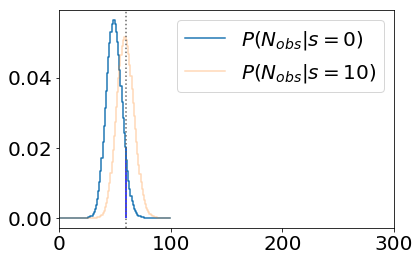

In [32]:
simple_example_poisson()  # only this is rendered on github


   * Note that exclusing the null-hypothesis doesn't mean that we consider the alternative hypothesis true.   
   * Note that what we have computed is $P(N_\text{obs} | \text{no signal})$, which can be written more generally as $P(\text{data}|\text{theory})$, so we are computing a probability about data. p-value is about data, not theory!
   * We are not computing a probability about the model ($P(\text{theory})$, which is what we want to know!)
   * Remember the definition of probability in the frequenstis approach $P(E) = \lim_{N\to\infty}\frac{n}{N}$, where $n$ is the number of occurrences of an event $E$ in $N$ trials. This can only be applied to repeatable events
   * Only in a Bayesian framework you can aswer (or compute the relative probability) questions like "Is there the Higgs boson?", "Will it rain tomorrow?", "Was Napoleon murdered?"
   
> "Bayesians address the question everyone is interested in, by using
> assumptions no-one believes"

> "Frequentists use impeccable logic to deal with an issue of no interest to
>anyone"
L. Lyons
  

   

## Expected significance

Let evaluate the expected significance as a function of the luminosity $L$. The number of expected signal and background are: $$b = L\times\sigma_{bkg}\times\varepsilon_{bkg}$$ $$s = L\times\sigma_{sig}\times\varepsilon_{sig}$$ Compute the expected significance from the p-value from the Poisson model, $s/\sqrt{b}$ and $\sqrt{2  ((s + b)  \log(1 + s / b) - s}$ assuming that there is signal.

$$\text{p-value} = \sum_{n\geq n_\text{obs}} \text{Pois}(n|b)$$

we need to consider $$n_\text{obs}\sim\text{Pois}[s+b]$$

In this case the signal model enters in the expected p-value computation. Let use toys, we will obtain a distribuion for the p-value.

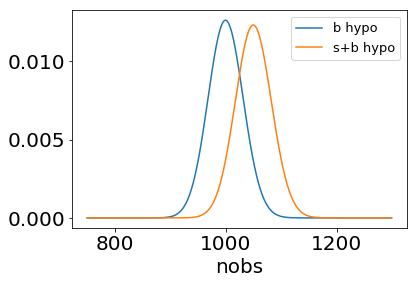

In [33]:
s, b = 50., 1000.  # expected values

xs = np.arange(750, 1300, 1)
plt.plot(xs, stats.poisson(b).pmf(xs), label='b hypo')
plt.plot(xs, stats.poisson(b + s).pmf(xs), label='s+b hypo')
plt.xlabel('nobs'); plt.legend(loc=0, fontsize=13); plt.show()

def compute_sensitivity_toys(nsignal_exp, nbkg_exp, NTOYS):
    X_sb = stats.poisson(nsignal_exp + nbkg_exp)
    X_b = stats.poisson(nbkg_exp)
    nobs = X_sb.rvs(size=NTOYS)             # generate the toys under s+b hypothesis
    pvalues = X_b.sf(nobs) + X_b.pmf(nobs)  # compute pvalues under b-hypothesis
    return pvalues

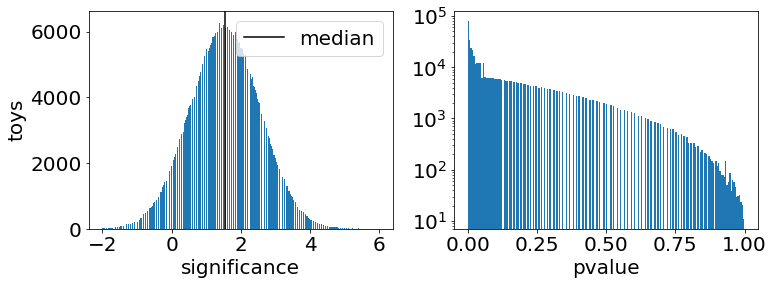

In [34]:
all_pvalues = compute_sensitivity_toys(s, b, NTOYS=500000)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].hist(p2z(all_pvalues), bins=np.linspace(-2, 6, 400))
axs[0].axvline(p2z(np.median(all_pvalues)), color='k', label='median')
axs[0].set_xlabel('significance'); axs[0].set_ylabel('toys')
axs[0].legend()

axs[1].hist(all_pvalues, bins=200)
axs[1].set_xlabel('pvalue'); axs[1].set_yscale('log')
plt.show()

In [35]:
def eval_sensitivity(bkg_xsec=1000., signal_xsec_exp=10.,
                      signal_efficiency=0.8, bkg_rejection=100.,
                      max_lumi=8.,
                      NTOYS=50000):
    luminosities = np.linspace(1E-9, max_lumi, 200)

    pvalues, zs = [], []
    for lumi in luminosities:
        nsignal_exp = lumi * signal_xsec_exp * signal_efficiency
        nbkg_exp = lumi * bkg_xsec / bkg_rejection
        ps = compute_sensitivity_toys(nsignal_exp, nbkg_exp, NTOYS)
        pvalues.append(ps)
        zs.append(p2z(ps))

    s = luminosities * signal_xsec_exp * signal_efficiency  
    b = luminosities * bkg_xsec / bkg_rejection
    
    approximation_z = s / np.sqrt(b)
    formula_z = np.sqrt(2 * ((s + b) * np.log(1 + s / b) - s))
        
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    axs[0].plot(luminosities, np.median(zs, axis=1), label='median-$z$ (toys)')
    axs[0].plot(luminosities, approximation_z, '--', label='$s/\sqrt{b}$')
    axs[0].plot(luminosities, formula_z, '--', label='$\sqrt{2 ((s + b)  \log(1 + s / b) - s)}$')
    axs[0].set_ylim(0, 7); axs[1].set_ylim(1E-8, 0.5)
    axs[0].set_ylabel('significance (toys)'); 
    axs[0].text(0.05, 0.8, '$s=L\sigma_S\epsilon_S = %.2f L$' % (signal_xsec_exp * signal_efficiency), transform=axs[0].transAxes)
    axs[0].text(0.05, 0.9, '$b=L\sigma_b\epsilon_b = %.2f L$' % (bkg_xsec / bkg_rejection), transform=axs[0].transAxes)
    axs[1].semilogy(luminosities, np.median(pvalues, axis=1), label='median-$p_0$ (toys)')
    axs[1].set_ylabel('$p_0$')
    
    axs[1].hlines([z2p(z) for z in range(7)], 1E-9, max_lumi, linestyles='--', alpha=0.3)
    axs[1].semilogy(luminosities, z2p(approximation_z), '--', label='$s/\sqrt{b}$')
    axs[1].semilogy(luminosities, z2p(formula_z), '--', label='$\sqrt{2 ((s + b)  \log(1 + s / b) - s)}$')
  
    for ax in axs.flat:
        ax.set_xlabel('luminosity'); ax.legend(loc=0, fontsize=15)
    plt.show()

In [36]:
eval_sensitivity = interact(eval_sensitivity, bkg_xsec=(10, 10000),
                            signal_xsec_exp=(0.1, 20),
                            signal_efficiency=(0.7, 1, 0.01),
                            bkg_rejection=(3, 500, 10),
                            max_lumi=(1, 100))

interactive(children=(IntSlider(value=1000, description='bkg_xsec', max=10000, min=10), FloatSlider(value=10.0…

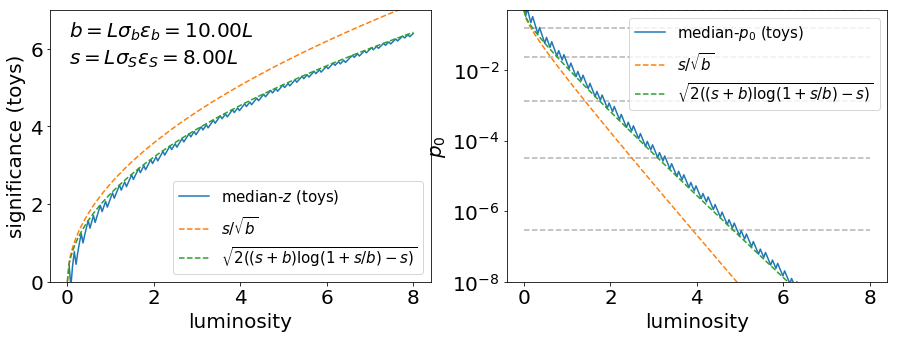

In [37]:
eval_sensitivity()  # only this is rendered on github

### Exercize
Derive the expression for the median expected significance and its approximation when $s\ll b$. Hint: use likelihood ratio and then use gaussian approximation of the Poisson distribution.

### RooFit 1.0.1

In [54]:
ws_example = ROOT.RooWorkspace('ws_example')
ws_example.factory("RooGaussian:signal(x[-5, 5], mean[0, -1, 1], sigma[1, 0.1, 2])")
x = ws_example.var('x')
data = ws_example.pdf('signal').generate(ROOT.RooArgSet(x), 1000)
ws_example.pdf('signal').fitTo(data);

 **********
 **    1 **SET PRINT           1
 **********
 **********
 **    2 **SET NOGRAD
 **********
 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 mean         0.00000e+00  2.00000e-01   -1.00000e+00  1.00000e+00
     2 sigma        1.00000e+00  1.90000e-01    1.00000e-01  2.00000e+00
 **********
 **    3 **SET ERR         0.5
 **********
 **********
 **    4 **SET PRINT           1
 **********
 **********
 **    5 **SET STR           1
 **********
 NOW USING STRATEGY  1: TRY TO BALANCE SPEED AGAINST RELIABILITY
 **********
 **    6 **MIGRAD        1000           1
 **********
 FIRST CALL TO USER FUNCTION AT NEW START POINT, WITH IFLAG=4.
 START MIGRAD MINIMIZATION.  STRATEGY  1.  CONVERGENCE WHEN EDM .LT. 1.00e-03
 FCN=1441.77 FROM MIGRAD    STATUS=INITIATE        8 CALLS           9 TOTAL
                     EDM= unknown      STRATEGY= 1      NO ERROR MATRIX       
  EXT PARAMETER               CURRENT GUESS       STEP         FIRST   
  NO

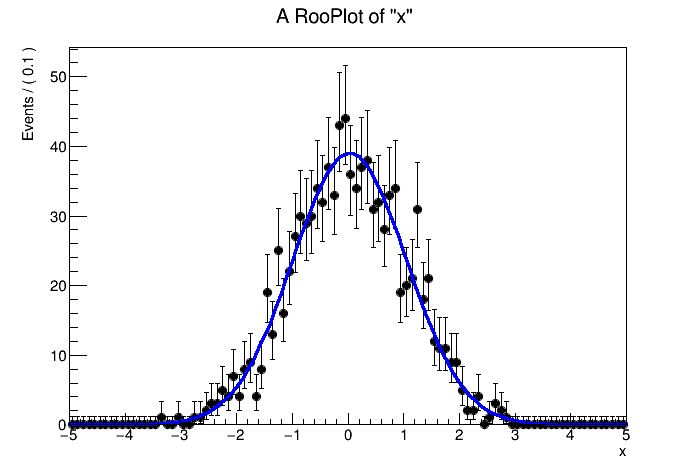

In [55]:
frame = x.frame()
data.plotOn(frame)
ws_example.pdf('signal').plotOn(frame)
canvas = ROOT.TCanvas()
frame.Draw()
canvas.Draw()

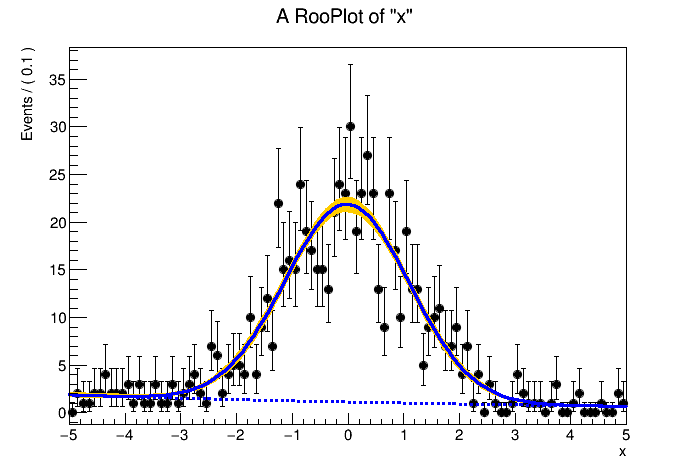

In [65]:
ws_example.factory("RooExponential:background(x, tau[-0.1])")
model = ws_example.factory("SUM:model(s[500, 0, 2000] * signal, b[200, 0, 5000] * background)")
frame = x.frame()
data = ws_example.pdf("model").generate(ROOT.RooArgSet(x))
data.plotOn(frame)
result = model.fitTo(data, RooFit.Save(), RooFit.PrintLevel(-1))
model.plotOn(frame, RooFit.VisualizeError(result, 1), RooFit.FillColor(ROOT.kOrange), RooFit.DrawOption("F"))
model.plotOn(frame)
model.plotOn(frame, RooFit.Components('background'), RooFit.LineStyle(ROOT.kDashed))
canvas = ROOT.TCanvas(); frame.Draw(); canvas.Draw()

## Counting models with RooFit / RooStats

In [66]:
S, B = 10, 20  # expected values

ws_poisson = ROOT.RooWorkspace('ws_poisson')  # create the workspace
b = ws_poisson.factory("b[%f]" % B)  # create constant variable
n_exp = ws_poisson.factory("sum::n_exp(s[%f], b)" % S)  # S + B
# create a Poisson pdf, with n_exp expected events
pdf = ws_poisson.factory("Poisson::pdf(n_obs[0, 100], n_exp)")
# generate a random experiment with S + B
aset = ROOT.RooArgSet(ws_poisson.var('n_obs'))
data = pdf.generate(aset, 1)  # generate with 1 entry
n_obs_val = data.get(0).first().getVal()

### Question
Explain why for a counting experiment we generate a dataset with 1 entry

We expect to observe $s+b =$ {{S}} + {{B}} = {{n_exp.getVal()}} events if there is a signal and {{B}} if there is only background. We observe {{n_obs_val}}. Is there a signal?

We have just defined the pdf(s) and the variables of the model, but the meaning of the various items is not defined (what is our observables?). `ModelConfig`: it bind the RooFit world (just define the model) to RooStats world (do inference with the model).

Create two `ModelConfig`s for null (bkg-only) and alternate hypothesis (s+b)

In [67]:
# create a MC linked to the ws
sbModel = RooStats.ModelConfig("sbmodel", ws_poisson)   
sbModel.SetPdf(pdf)
sbModel.SetObservables('n_obs')  # it understands variable-names
sbModel.SetParametersOfInterest('s')
# save the value of s for (s+b)-hypothesis
sbModel.SetSnapshot(ROOT.RooArgSet(ws_poisson.var('s')))
getattr(ws_poisson, 'import')(sbModel)  # import is a keyword in python

bModel = sbModel.Clone("bmodel")  # create a bkg-only model
ws_poisson.var('s').setVal(0)             # with no signal
bModel.SetSnapshot(ROOT.RooArgSet(ws_poisson.var('s')))
getattr(ws_poisson, 'import')(bModel);

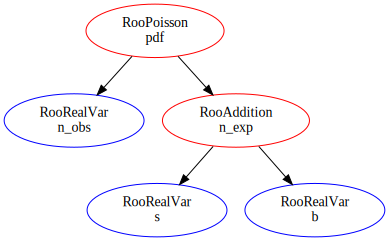

In [68]:
pdf.graphVizTree("pdf_graph.dot")
!dot -Tsvg pdf_graph.dot > pdf_graph.svg; rm pdf_graph.dot
SVG("pdf_graph.svg")

In [69]:
ws_poisson.Print()


RooWorkspace(ws_poisson) ws_poisson contents

variables
---------
(b,n_obs,s)

p.d.f.s
-------
RooPoisson::pdf[ x=n_obs mean=n_exp ] = 7.63019e-09

functions
--------
RooAddition::n_exp[ s + b ] = 20

parameter snapshots
-------------------
sbmodel__snapshot = (s=10[C])
bmodel__snapshot = (s=0[C])

named sets
----------
bmodel__snapshot:(s)
sbmodel_Observables:(n_obs)
sbmodel_POI:(s)
sbmodel__snapshot:(s)

generic objects
---------------
RooStats::ModelConfig::sbmodel
RooStats::ModelConfig::bmodel



As we have done before, for the simple counting experiment, we have used as statistic the observables directly: `n_obs`. 

In [70]:
test = RooStats.NumEventsTestStat(pdf)
test.Evaluate(data, ROOT.RooArgSet(ws_poisson.var('s')))

32.0

The only missing ingredient is the distribution of the statistics, but in this trivial example we have defied it to be the number of observed events, so it is Poissonian by definition. What to do in more complicated case (many entries for 1 events, or just in case I want to use the squared number of events)?
   * rely on asymtotic formulas (if any)
   * general and expensive method: run pseudo-experiments (toys), see next slide

## Usage of `ToyMCSampler`

In [ ]:
ROOT.RooMsgService.instance().getStream(1).removeTopic(ROOT.RooFit.NumIntegration)
ROOT.RooMsgService.instance().getStream(1).removeTopic(ROOT.RooFit.Fitting)
ROOT.RooMsgService.instance().getStream(1).removeTopic(ROOT.RooFit.Minimization)
ROOT.RooMsgService.instance().getStream(1).removeTopic(ROOT.RooFit.InputArguments)
ROOT.RooMsgService.instance().getStream(1).removeTopic(ROOT.RooFit.Eval)
ROOT.RooMsgService.instance().getStream(1).removeTopic(ROOT.RooFit.DataHandling)
ROOT.RooMsgService.instance().setGlobalKillBelow(ROOT.RooFit.ERROR)

In [71]:


toy_sampler = RooStats.ToyMCSampler(test, 100000)  # configure the number of toys
toy_sampler.SetNEventsPerToy(1)                    # it is a counting experiment
toy_sampler.SetObservables(bModel.GetObservables())
toy_sampler.SetParametersForTestStat(bModel.GetParametersOfInterest())
toy_sampler.SetPdf(pdf)

test_distribution_b = toy_sampler.GetSamplingDistribution(
    bModel.GetParametersOfInterest())

plot_test_distribution = RooStats.SamplingDistPlot(60, 0, 60)
cuts = [test_distribution_b.InverseCDF(1 - z2p(z)) for z in range(1, 4)]
for cut in cuts:
    plot_test_distribution.AddSamplingDistributionShaded(test_distribution_b, -1000, cut)
plot_test_distribution.AddSamplingDistribution(test_distribution_b)

canvas = ROOT.TCanvas()
plot_test_distribution.Draw()

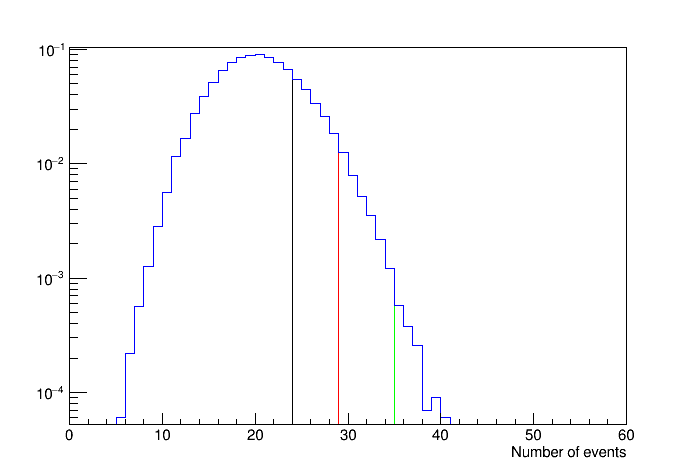

In [73]:
canvas.SetLogy()
canvas.Draw()

We observed {{n_obs_val}}. The values corresponding to significance of 1,2,3,4 are shown. Too many toys are needed for high-significance, since we have to probe the tail of the distribution. Frequentist approach very expensive.

Let use the `FrequentistCalculator` to compute the $p_0$ which use the `ToyMCCalculator` for both the hypotheses to compute the p-values. `FrequentistCalculator` is a `HypoTestCalculator` and returns a `HypoTestResults` via `GetHypoTest`, which contain the test results (p-values, ...)

In [74]:
# the sb model is not really needed in this case
hypoCalc = RooStats.FrequentistCalculator(data, sbModel, bModel)
hypoCalc.SetToys(20000, 1000)  # generate much more toys for bkg-only

toy_sampler = hypoCalc.GetTestStatSampler()
toy_sampler.SetTestStatistic(test)  # our test statistics
toy_sampler.SetNEventsPerToy(1)

htr = hypoCalc.GetHypoTest()
htr.SetPValueIsRightTail(True)  # the "extreme" cases are on the right tail
htr.SetBackgroundAsAlt(False)

(frequentist)        p0 = 0.0088 ± 0.0007  z = 2.37 ± 0.03
(from Poisson distr) p0 = 0.0081  z = 2.40


<IPython.core.display.Latex object>

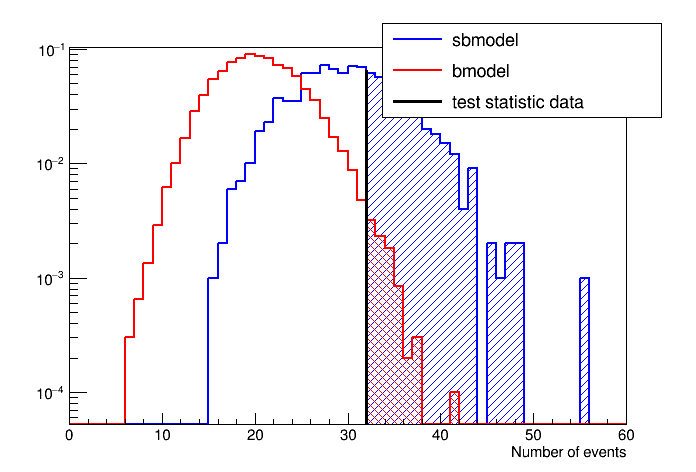

In [76]:
plot = RooStats.HypoTestPlot(htr, 60, 0, 60)  # 60 bins
canvas = ROOT.TCanvas(); plot.Draw(); canvas.SetLogy(); canvas.Draw()
print("(frequentist)        p0 = %.2g ± %.1g  z = %.2f ± %.1g" % (htr.NullPValue(), htr.NullPValueError(), htr.Significance(), htr.SignificanceError()))
p0_poisson = stats.poisson(B).sf(n_obs_val) + stats.poisson(B).pmf(n_obs_val)
print("(from Poisson distr) p0 = %.2g  z = %.2f" % (p0_poisson, p2z(p0_poisson)))
Latex("$\sqrt{2(n \log(n/b) + b - n)} = %.2f$" % np.sqrt(2 * (n_obs_val * np.log(n_obs_val / B) + B - n_obs_val)))

## Example of test-statistics

A famous journalist makes a regular survey every day, using a sample of 1000 random people. One day the fraction of citizen who trust the government is 55%, while the day after is 51%. Can we say there is a change in opinions (using $\alpha=5\%$)?

Let's write the contingency table

| y/n   | day1    | day2  | total |
|-------|---------|-------|-------|
| yes   |   550   |  510  |  1060 |
| no    |   450   |  490  |   940 |
| total |  1000   | 1000  |  2000 |

Null hypothesis: day1 and day2 are from the same population. What will be the expected contingency table in that case?

In [77]:
table = pd.DataFrame([[550, 510], [450, 490]], columns=['day1', 'day2'], index=['yes', 'no'])
pd.DataFrame(stats.contingency.expected_freq(table), columns=['day1', 'day2'], index=['yes', 'no'])

,day1,day2
yes,530.0,530.0
no,470.0,470.0


Define the test statistics: $\chi^2 = \sum_{i,j}\frac{(O_{i,j}-E_{i,j})^2}{E_{i,j}}$ where $O$ and $E$ are the observed and expected values, while the index $i,j$ identify a cell of the table. The test statistics $\chi^2$ is approximatively distributed as a $\chi^2$-distribution with $(\text{nrows} - 1)(\text{ncolumns} - 1)=1$ degree of freedom.

In [79]:
chi2, p, dof, _ = stats.contingency.chi2_contingency(table)
print("chi2 = %.2f ndof = %d p-value = %.3e" % (chi2, dof, p))

chi2 = 3.05 ndof = 1 p-value = 8.059e-02


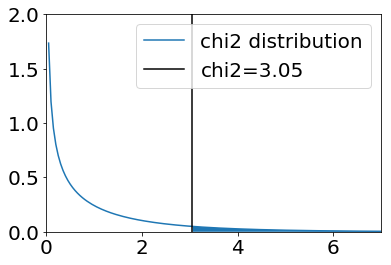

p-value = 8.059e-02


In [95]:
xx = np.linspace(0, 10, 200)
chi2_dist = stats.chi2(1)
plt.plot(xx, chi2_dist.pdf(xx), label='chi2 distribution')
plt.fill_between(xx[xx >= chi2], chi2_dist.pdf(xx[xx >= chi2]))
plt.axvline(chi2, color='k', label='chi2=%.2f' % chi2)
plt.ylim(0, 2); plt.xlim(0, 7), plt.legend(); plt.show()
print('p-value = %.3e' % (chi2_dist.sf(chi2)))

We can't reject the null hypothesis. The exact solution is made with the Fisher exact test, which used the hypergeometric distribution

In [97]:
print("p-value = %.3e" % stats.fisher_exact(table)[1])

p-value = 8.056e-02
